In [110]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.quantum_info import Operator, Pauli, SparsePauliOp
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient

from qiskit.circuit.library import QFT, RealAmplitudes, TwoLocal
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B

from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.tools.visualization import circuit_drawer

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeManila

#from qiskit.aqua.components.initial_states import VarFormBased, Custom
# Import useful packages

import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

#IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
#set Backends
#simulators
backend_stv = Aer.get_backend('statevector_simulator')
backend_qsm = Aer.get_backend('qasm_simulator')
#Noisy simulator
backend_noi = Aer.get_backend('aer_simulator')
device_backend=FakeManila()
device = QasmSimulator.from_backend(device_backend)
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
#Real Devices
backend_manil = provider.get_backend('ibmq_manila')
#backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')
sh=1024
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()


In [22]:
provider.backends(simulator=False, operational=True)

[<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [127]:
q=4 #qubits
n=2**q #dimension
coup=0.2 #coupling
alpha=coup/(np.math.factorial(3)) #cubic coupling
#alpha=coup/3
beta=coup/(np.math.factorial(4)) #quartic coupling
#beta=coup/4

In [128]:
#Position Basis

#Position Operator
Xo=np.zeros(shape=(n,n)).astype(complex)
for i in range (n):
    Xo[i][i]=np.sqrt(2*np.pi/(n))*(2*(i+1)-n-1)/2


#Fourier transform
F=np.zeros(shape=(n,n)).astype(complex)
for i in range(n):
    for j in range(n):
        F[i][j]=np.exp(complex(0,2*np.pi/n)*((2*(i+1)-n-1)/2)*((2*(j+1)-n-1)/2))/np.sqrt(n)

#Momentum Operator
P=np.matmul(np.matmul(F.conj().T,Xo),F)

#Harmonic Oscillator
H=np.matmul(Xo,Xo)/2+np.matmul(P,P)/2
H_eigenv=np.sort(np.linalg.eig(H)[0].real) #Eigenvalues

#Cubic Anharmoinic Oscilator
CH=np.matmul(Xo,Xo)/2+np.matmul(P,P)/2 - alpha*np.linalg.matrix_power(Xo,3)
CH_eigenv=np.sort(np.linalg.eig(H)[0].real) #EigenValues

#Quadratic Anharmoinic Oscilator
QH=np.matmul(Xo,Xo)/2+np.matmul(P,P)/2 + beta*np.linalg.matrix_power(Xo,4)
QH_eigenv=np.sort(np.linalg.eig(H)[0].real) #EigenValues

#Ladder operators
A=np.sqrt(1/2)*(Xo+complex(0,1)*P)
A_dag=A.conj().T

In [129]:
#Spectrums

#Harmonic Oscillator Spectrum
HO_eigv=np.empty([n][0])
for i in range(n):
    HO_eigv[i]=i+(1/2)
    
#Cubic Anaharmonic Oscillator Spectrum
CAHO_eigv=np.empty([n][0])
for i in range(n):
    CAHO_eigv[i]=i+(1/2)+(5/12)*coup*((i**2)+i+11/30)
    
#Quartic Anharmonic Oscillator Spectrum    
QAHO_eigv=np.empty([n][0])
for i in range(n):
    QAHO_eigv[i]=i+(1/2)+(3/8)*coup*((i**2)+i+1/2)-(1/64)*(coup**2)*(17*(i**3)+(51/2)*i**2+(59/2)*i+21/2)

In [130]:
#Energy Basis

#Ladder operator and identity
AE = np.zeros(shape=(n,n)).astype(complex)
idt= np.zeros(shape=(n,n)).astype(complex)

for i in range(n+1):
    for j in range(n+1):
        if j-i==1:
            AE[i-1][j-1]=np.sqrt(j-1)
for i in range(n+1):
    for j in range(n+1):
        if j==i:
            idt[i-1][j-1]=1
AE_dag=AE.conj().T

XE=(np.sqrt(1/2))*(AE_dag+AE) #Position Operator
PE=complex(0,np.sqrt(1/2))*(AE_dag-AE) #Momentum Operator
HOE=np.matmul(AE_dag,AE) +(1/2)*idt #Harmonic Oscillator
CAHOE=np.matmul(AE_dag,AE) + ((1/2)*idt) - alpha*np.linalg.matrix_power(XE,3) # Cubic Anaharmonic Oscillator
QAHOE=np.matmul(AE_dag,AE) + ((1/2)*idt) + beta*np.linalg.matrix_power(XE,4) #Quartic Anaharmonic Oscillator

#Eigenvalues
HOE_eigenv=np.linalg.eig(HOE)[0].real
CAHOE_eigenv=np.linalg.eig(CAHOE)[0].real
QAHOE_eigenv=np.linalg.eig(QAHOE)[0].real

    
HOE_eigenv=np.sort(HOE_eigenv)    
CAHOE_eigenv=np.sort(CAHOE_eigenv)
QAHOE_eigenv=np.sort(QAHOE_eigenv)

np.linalg.det(HOE)
np.linalg.det(CAHOE)
np.linalg.det(QAHOE)

(10834295127949.334+0j)

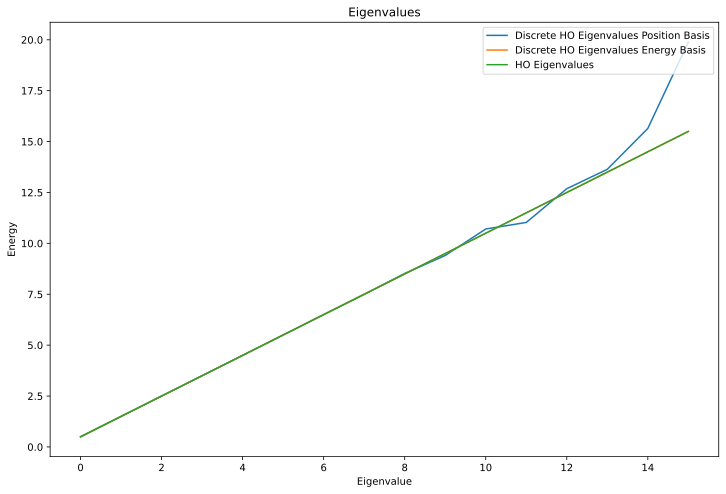

In [131]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(np.arange(0,n,1), H_eigenv, label='Discrete HO Eigenvalues Position Basis')
pylab.plot(np.arange(0,n,1), HOE_eigenv, label='Discrete HO Eigenvalues Energy Basis')
pylab.plot(np.arange(0,n,1), HO_eigv, label='HO Eigenvalues')
pylab.xlabel('Eigenvalue')
pylab.ylabel('Energy')
pylab.title('Eigenvalues')
pylab.legend(loc='upper right');

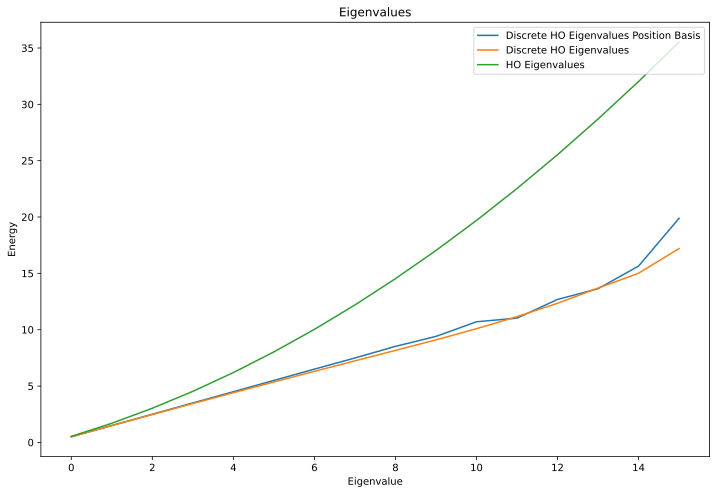

In [132]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(np.arange(0,n,1), CH_eigenv, label='Discrete HO Eigenvalues Position Basis')
pylab.plot(np.arange(0,n,1), CAHOE_eigenv, label='Discrete HO Eigenvalues')
pylab.plot(np.arange(0,n,1), CAHO_eigv, label='HO Eigenvalues')
pylab.xlabel('Eigenvalue')
pylab.ylabel('Energy')
pylab.title('Eigenvalues')
pylab.legend(loc='upper right');

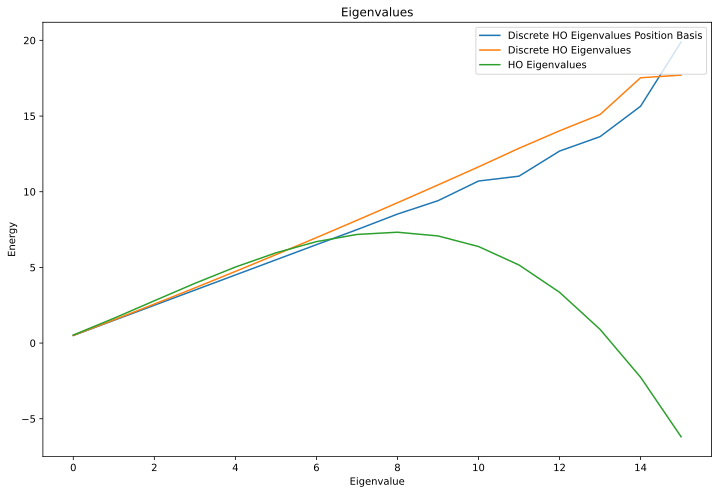

In [133]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(np.arange(0,n,1), QH_eigenv, label='Discrete HO Eigenvalues Position Basis')
pylab.plot(np.arange(0,n,1), QAHOE_eigenv, label='Discrete HO Eigenvalues')
pylab.plot(np.arange(0,n,1), QAHO_eigv, label='HO Eigenvalues')
pylab.xlabel('Eigenvalue')
pylab.ylabel('Energy')
pylab.title('Eigenvalues')
pylab.legend(loc='upper right');

In [134]:
HOE_OP=Operator(HOE) #Qiskit operators
CAHOE_OP=Operator(CAHOE)
QAHOE_OP=Operator(QAHOE)

P_HOE_OP=PauliSumOp(SparsePauliOp.from_operator(HOE_OP),coeff=1.0) #PauliSum OPs
P_CAHOE_OP=PauliSumOp(SparsePauliOp.from_operator(CAHOE_OP),coeff=1.0)
P_QAHOE_OP=PauliSumOp(SparsePauliOp.from_operator(QAHOE_OP),coeff=1.0)


In [135]:
#Variatonal Forms
def Var_form_set(q,d,ent,cont):
    if cont==1:
        vf_TL = TwoLocal(
            num_qubits=q,
            reps=d,
            rotation_blocks=['ry','rz'],
            entanglement_blocks='cx',
            entanglement=ent,
            )
        return vf_TL
    vf_RA=RealAmplitudes(
        num_qubits=q,
        reps=d,
        entanglement=ent,
        )
    return vf_RA

In [136]:
vf=Var_form_set(q,1,'linear',0)
print(vf.decompose())

     ┌──────────┐     ┌──────────┐                        
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[4]) ├────────────────────────
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐            
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[5]) ├────────────
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──────────┐
q_2: ┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[6]) ├
     ├──────────┤        └───┘       ┌─┴─┐    ├──────────┤
q_3: ┤ Ry(θ[3]) ├────────────────────┤ X ├────┤ Ry(θ[7]) ├
     └──────────┘                    └───┘    └──────────┘


In [139]:
#define Quantum Instance and number of runs

seed = 62
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed)
nois_qi = QuantumInstance(backend=backend_noi, seed_simulator=seed, seed_transpiler=seed,
                          coupling_map=coupling_map, noise_model=noise_model,)
optimizers = [COBYLA(maxiter=1500), L_BFGS_B(maxiter=1500), SLSQP(maxiter=1500), SPSA(maxiter=1500)]
gradients=[Gradient(grad_method='param_shift'),Gradient(grad_method='lin_comb'),Gradient(grad_method='fin_diff')]

VQE Results: [0.5003528336533488, 0.5000000000005732, 0.5000000671866023, 0.5019526555679362]
Exact Result: 0.50000


Runtime: 0:00:16.075820
Runtime for  COBYLA : 0:00:00.416093
Runtime for  L_BFGS_B : 0:00:10.189791
Runtime for  SLSQP : 0:00:04.747203
Runtime for  SPSA : 0:00:00.721030


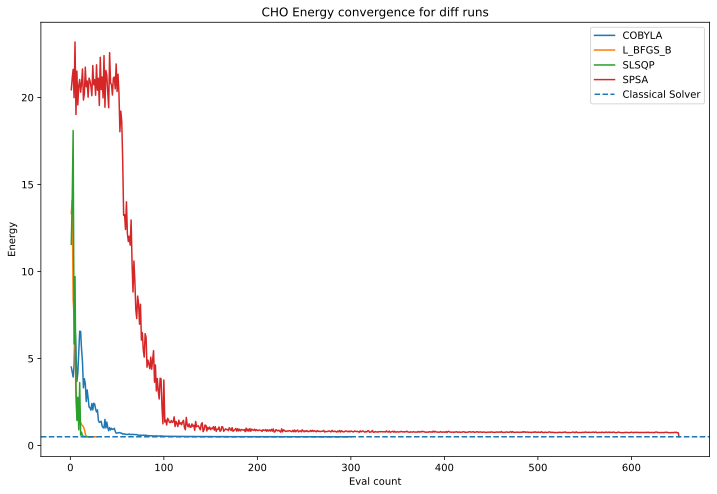

In [104]:
#QHO Statevector simulator 1 reps; 300 trials.
begin = datetime.now()

vqe_energies=[]
vqe_opt_pts=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback,gradient=gradients[1])
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_HOE_OP)
    opt_pts=vqe_result.optimal_point
    vqe_opt_pts.append(opt_pts)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

VQE Results: [0.498752956033697, 0.49873999585799617, 0.4987401122657216, 0.5662573504028594]
Exact Result: 0.49845


Runtime: 0:00:01.588811
Runtime for  COBYLA : 0:00:00.282321
Runtime for  L_BFGS_B : 0:00:00.607284
Runtime for  SLSQP : 0:00:00.185670
Runtime for  SPSA : 0:00:00.481397


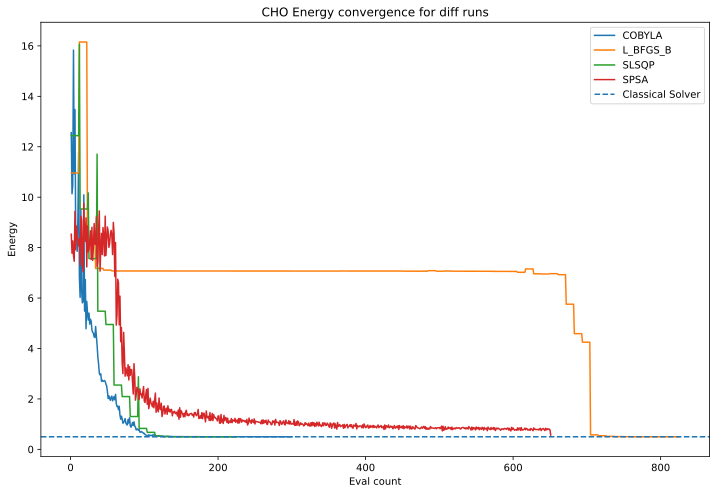

In [105]:
#CAQHO Statevector simulator 1 reps; 300 trials; no Init_point.
begin = datetime.now()

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback)
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

VQE Results: [0.4987402278413695, 0.4987399958970265, 0.49874005849013187, 6.746530940283786]
Exact Result: 0.49845


Runtime: 0:00:00.990257
Runtime for  COBYLA : 0:00:00.291696
Runtime for  L_BFGS_B : 0:00:00.119743
Runtime for  SLSQP : 0:00:00.050922
Runtime for  SPSA : 0:00:00.495543


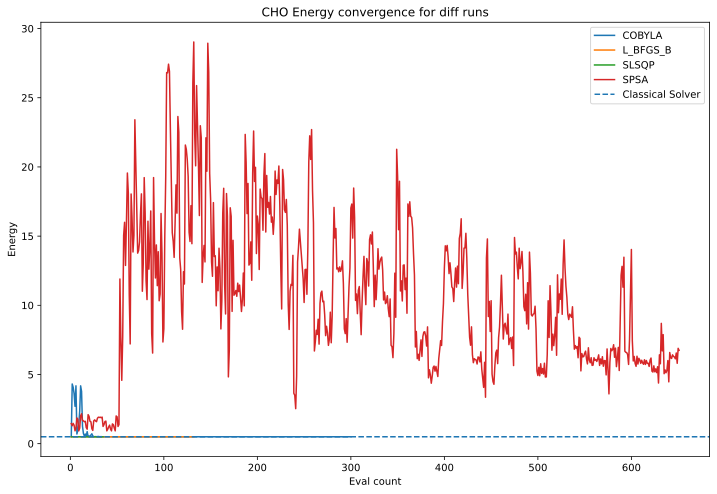

In [106]:
#CAQHO Statevector simulator 1 reps; 300 trials; Init_point.
begin = datetime.now()

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback,initial_point=vqe_opt_pts[1])
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

VQE Results: [0.5064189546882885, 0.5060788025662468, 0.5062255557781148, 0.6333291903611856]
Exact Result: 0.50608


Runtime: 0:00:01.183428
Runtime for loop COBYLA : 0:00:00.281102
Runtime for loop L_BFGS_B : 0:00:00.234181
Runtime for loop SLSQP : 0:00:00.153642
Runtime for loop SPSA : 0:00:00.478981


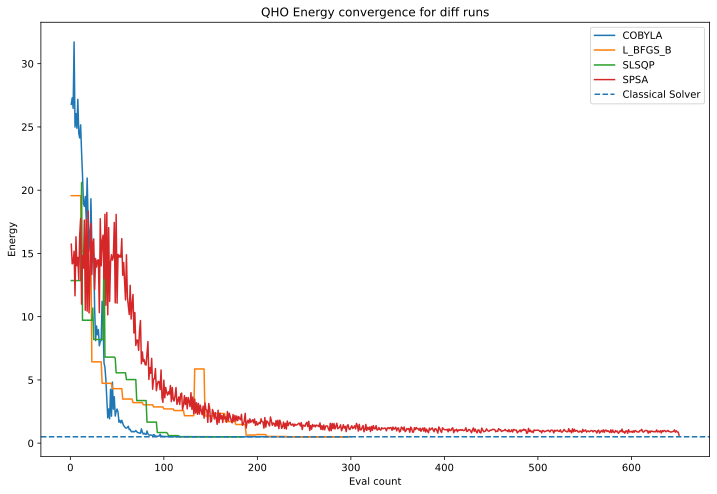

In [107]:
#QAQHO Statevector simulator 1 reps; 300 trials; no init_point.
begin = datetime.now()

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback)
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for loop",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('QHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

VQE Results: [0.5060789240396437, 0.5060994085199805, 0.5060996214205764, 7.450897641695989]
Exact Result: 0.50608


Runtime: 0:00:00.885534
Runtime for loop COBYLA : 0:00:00.239218
Runtime for loop L_BFGS_B : 0:00:00.082037
Runtime for loop SLSQP : 0:00:00.042328
Runtime for loop SPSA : 0:00:00.486856


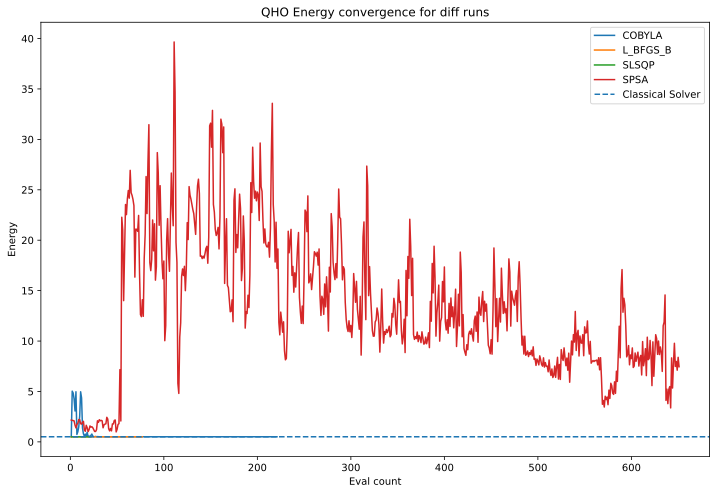

In [108]:
#QAQHO Statevector simulator 1 reps; 300 trials; init_point.
begin = datetime.now()

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=qi,callback=callback,initial_point=vqe_opt_pts[1])
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_QAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for loop",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('QHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

In [142]:
#define Quantum Instance and number of runs

seed = 62
algorithm_globals.random_seed = seed
qi = QuantumInstance(backend_stv, seed_transpiler=seed, seed_simulator=seed)
nois_qi = QuantumInstance(backend=backend_noi, seed_simulator=seed, seed_transpiler=seed,
                          coupling_map=coupling_map, noise_model=noise_model,)
optimizers = [COBYLA(maxiter=300), L_BFGS_B(maxiter=300), SLSQP(maxiter=300), SPSA(maxiter=300)]
gradients=[Gradient(grad_method='param_shift'),Gradient(grad_method='lin_comb'),Gradient(grad_method='fin_diff')]

VQE Results: [0.8632812500000006, 0.9052734375, 2.7939453125000004, 1.1855468750000002]
Exact Result: 0.50000


Runtime: 0:00:46.106658
Runtime for  COBYLA : 0:00:02.222888
Runtime for  L_BFGS_B : 0:00:21.990067
Runtime for  SLSQP : 0:00:03.805159
Runtime for  SPSA : 0:00:18.084770


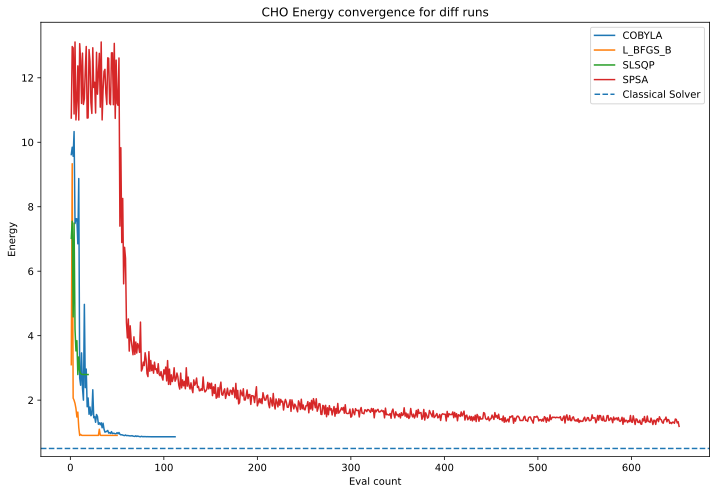

In [145]:
#QHO Simulated noise 1 rep; 1500 trial

begin = datetime.now()

vqe_energies=[]
vqe_opt_pts=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)
vf=Var_form_set(q,1,'linear',0)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=nois_qi,callback=callback,gradient=gradients[1])
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_HOE_OP)
    opt_pts=vqe_result.optimal_point
    vqe_opt_pts.append(opt_pts)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_HOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

VQE Results: [1.1088958559047923, 6.962186199536501, 6.758884631759126, 1.8525859094107948]
Exact Result: 0.49845


Runtime: 0:01:35.668127
Runtime for  COBYLA : 0:00:15.392709
Runtime for  L_BFGS_B : 0:00:01.409994
Runtime for  SLSQP : 0:00:01.408348
Runtime for  SPSA : 0:01:17.443117


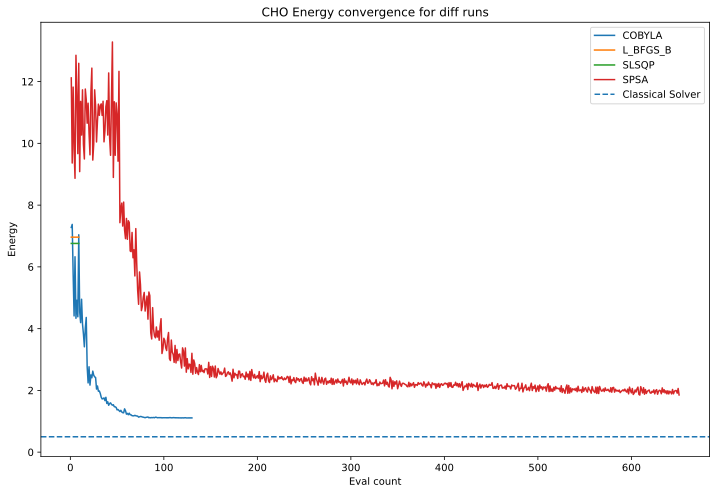

In [147]:
#CAQHO noisy simulator 1 reps; 300 trials; no Init_point.
begin = datetime.now()

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=nois_qi,callback=callback)
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

VQE Results: [0.7876796019643142, 0.9421900645102993, 0.9421900645102993, 0.8746339235676102]
Exact Result: 0.49845


Runtime: 0:01:30.068994
Runtime for  COBYLA : 0:00:11.638362
Runtime for  L_BFGS_B : 0:00:01.384753
Runtime for  SLSQP : 0:00:01.292147
Runtime for  SPSA : 0:01:15.740307


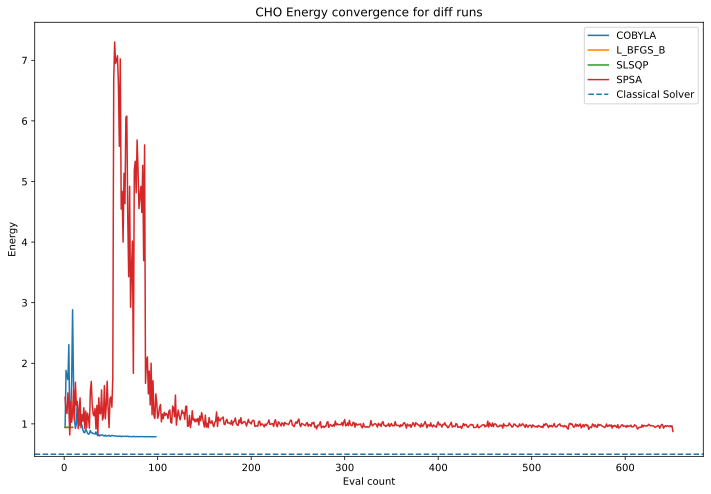

In [150]:
#CAQHO noisy simulator 1 reps; 300 trials: init_point.
begin = datetime.now()

vqe_energies=[]
Runtimes=[]
conv_cnts = np.empty(runs, dtype=object)
conv_vals = np.empty(runs, dtype=object)

for i, optimizer in enumerate(optimizers):
    beginl = datetime.now()
    vf=Var_form_set(q,1,'linear',0)
   

    counts=[]
    values=[]
    def callback(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    vqe = VQE(vf, optimizer,quantum_instance=nois_qi,callback=callback,initial_point=vqe_opt_pts[1])
    vqe_result=vqe.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
    vqe_eigenv=vqe_result.eigenvalue.real
    vqe_energies.append(vqe_eigenv)
    conv_cnts[i] = np.asarray(counts)
    conv_vals[i] = np.asarray(values)
    
    endl = datetime.now()
    Runtimes.append(endl-beginl)
print("VQE Results:", vqe_energies)
exact_solution = npme.compute_minimum_eigenvalue(operator=P_CAHOE_OP)
print(f'Exact Result: {exact_solution.eigenvalue.real:.5f}')

end = datetime.now()
print("\n")
print ("Runtime:",end-begin)
for i,optimizer in enumerate(optimizers):
    print ("Runtime for ",type(optimizer).__name__,":",Runtimes[i])
    
pylab.rcParams['figure.figsize'] = (12, 8)
for i,optimizer in enumerate(optimizers):
    pylab.plot(conv_cnts[i], conv_vals[i], label=type(optimizer).__name__)
pylab.axhline(y=exact_solution.eigenvalue.real,label='Classical Solver',linestyle='--')
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('CHO Energy convergence for diff runs')
pylab.legend(loc='upper right');

In [104]:
#Real device 1rep; 1 trial
melb_instance=QuantumInstance(backend_melb,shots=sh,skip_qobj_validation=False, optimization_level=3)

begin = datetime.now()
print ("Start date and time : ")
print (begin.strftime("%Y-%m-%d %H:%M:%S"))

optimizer = SPSA(max_trials=1)
vf=Var_form_set(q,1,'linear',0)
vqe = VQE(PM1,vf, optimizer)

vqe_result = np.real(vqe.run(melb_instance)['eigenvalue'])
print("VQE Results:", vqe_result)
exact_solution = NumPyEigensolver(PM1,k=1).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

end = datetime.now()
print ("End date and time : ")
print (end.strftime("%Y-%m-%d %H:%M:%S"))
print ("Runtime:",end-begin)

Start date and time : 
2020-05-22 13:29:58
VQE Results: 26.30078125
Exact Result: [0.5]
End date and time : 
2020-05-22 13:44:25
Runtime: 0:14:26.088888


In [126]:
q

5

In [100]:
#IBM QASM,noise 1 rep, 5000 trials
C_map=backend_melb.configuration().coupling_map
noise_model=NoiseModel.from_backend(backend_melb.properties())
IBM_qsm_instance=QuantumInstance(backend_qsm_ibm,shots=sh,
                                  coupling_map=C_map,
                                  skip_qobj_validation=False,
                                  measurement_error_mitigation_cls=CompleteMeasFitter,
                                  cals_matrix_refresh_period=30
                                  )
now = datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

vqe_energies=[]
vqe = VQE(PM1,vf , optimizer)

optimizer = SPSA(max_trials=5000)
vf=Var_form_set(q,1,'linear',0)
vqe = VQE(PM1,vf , optimizer)
vqe_result = np.real(vqe.run(IBM_qsm_instance)['eigenvalue'])
vqe_energies.append(vqe_result)
print("VQE Results:", vqe_energies)
exact_solution = NumPyEigensolver(PM1,k=1).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

now = datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))


Current date and time : 
2020-05-22 09:00:36


KeyboardInterrupt: 

In [83]:
print(vf)
circ=vf.assign_parameters(result_vqe['optimal_point'])
circ.draw()

     ┌──────────┐     ┌──────────┐                        ┌───────────┐»
q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[6]) ├─────────────────■──────┤ RY(θ[12]) ├»
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐   ┌─┴─┐    └───────────┘»
q_1: ┤ RY(θ[1]) ├┤ X ├─────■──────┤ RY(θ[7]) ├───┤ X ├──────────■──────»
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──┴───┴───┐    ┌─┴─┐    »
q_2: ┤ RY(θ[2]) ├────────┤ X ├─────────■──────┤ RY(θ[8]) ├────┤ X ├────»
     ├──────────┤        └───┘       ┌─┴─┐    └──────────┘ ┌──┴───┴───┐»
q_3: ┤ RY(θ[3]) ├────────────────────┤ X ├─────────■───────┤ RY(θ[9]) ├»
     ├──────────┤                    └───┘       ┌─┴─┐     └──────────┘»
q_4: ┤ RY(θ[4]) ├────────────────────────────────┤ X ├──────────■──────»
     ├──────────┤                                └───┘        ┌─┴─┐    »
q_5: ┤ RY(θ[5]) ├─────────────────────────────────────────────┤ X ├────»
     └──────────┘                                             └───┘    »
«                               ┌───────────┐      

┌─────────────┐     ┌────────────┐                              »
q_0: ┤ RY(-1.3197) ├──■──┤ RY(4.4435) ├──────────────────────■───────»
     ├─────────────┤┌─┴─┐└────────────┘┌─────────────┐     ┌─┴─┐     »
q_1: ┤ RY(-4.1303) ├┤ X ├──────■───────┤ RY(-1.4091) ├─────┤ X ├─────»
     ├─────────────┤└───┘    ┌─┴─┐     └─────────────┘┌────┴───┴────┐»
q_2: ┤ RY(-3.8147) ├─────────┤ X ├────────────■───────┤ RY(-2.2838) ├»
     └┬────────────┤         └───┘          ┌─┴─┐     └─────────────┘»
q_3: ─┤ RY(2.7253) ├────────────────────────┤ X ├────────────■───────»
      ├────────────┤                        └───┘          ┌─┴─┐     »
q_4: ─┤ RY(1.2693) ├───────────────────────────────────────┤ X ├─────»
      ├────────────┤                                       └───┘     »
q_5: ─┤ RY(5.4667) ├─────────────────────────────────────────────────»
      └────────────┘                                                 »
«     ┌─────────────┐                              ┌─────────────┐»
«q_0: ┤ RY(0.86052) ├──────────────────────■───────┤ RY(-3.4147) ├»
«     └─────────────┘ ┌─────────────┐    ┌─┴─┐     └─────────────┘»
«q_1: ───────■────────┤ RY(-4.0791) ├────┤ X ├────────────■───────»
«          ┌─┴─┐      └─────────────┘┌───┴───┴────┐     ┌─┴─┐     »
«q_2: ─────┤ X ├─────────────■───────┤ RY(3.4058) ├─────┤ X ├─────»
«     ┌────┴───┴─────┐     ┌─┴─┐     └────────────┘┌────┴───┴────┐»
«q_3: ┤ RY(-0.95898) ├─────┤ X ├───────────■───────┤ RY(-1.1012) ├»
«     └──────────────┘┌────┴───┴────┐    ┌─┴─┐     └─────────────┘»
«q_4: ───────■────────┤ RY(-5.2114) ├────┤ X ├────────────■───────»
«          ┌─┴─┐      ├─────────────┤    └───┘          ┌─┴─┐     »
«q_5: ─────┤ X ├──────┤ RY(-1.9607) ├───────────────────┤ X ├─────»
«          └───┘      └─────────────┘                   └───┘     »
«                                                                  
«q_0: ─────────────────────────────────────────────────────────────
«     ┌─────────────┐                                              
«q_1: ┤ RY(-1.1275) ├──────────────────────────────────────────────
«     └─────────────┘┌─────────────┐                               
«q_2: ───────■───────┤ RY(-2.2697) ├───────────────────────────────
«          ┌─┴─┐     └─────────────┘┌─────────────┐                
«q_3: ─────┤ X ├────────────■───────┤ RY(-2.0415) ├────────────────
«      ┌───┴───┴────┐     ┌─┴─┐     └─────────────┘┌──────────────┐
«q_4: ─┤ RY(1.5035) ├─────┤ X ├────────────■───────┤ RY(-0.18788) ├
«     ┌┴────────────┤     └───┘          ┌─┴─┐     ├─────────────┬┘
«q_5: ┤ RY(0.11094) ├────────────────────┤ X ├─────┤ RY(-3.1789) ├─
«     └─────────────┘                    └───┘     └─────────────┘

In [50]:
job = backend_melb.retrieve_job('5ec6e2c90644600014c83add')
vqe_result = np.real(job)

In [138]:
vqe_result

26.30078125

In [ ]:
circ = var_form.construct_circuit(result_vqe['opt_params'])
im = circuit_drawer(circ)

In [123]:
Fou_t=QFT(6,inverse=False,approximation_degree=0).inverse()
Fou_t.draw()

»
q213_0: ───────X────────────────────────────────────────────────────────»
               │                                                        »
q213_1: ────X──┼────────────────────────────────────────────────────────»
            │  │                                                        »
q213_2: ─X──┼──┼────────────────────────────────────■────────────■──────»
         │  │  │                                    │      ┌───┐ │      »
q213_3: ─X──┼──┼────────────────────■───────■───────┼──────┤ H ├─┼──────»
            │  │              ┌───┐ │       │-pi/2  │      └───┘ │-pi/4 »
q213_4: ────X──┼───────■──────┤ H ├─┼───────■───────┼────────────■──────»
               │ ┌───┐ │-pi/2 └───┘ │-pi/4          │-pi/8              »
q213_5: ───────X─┤ H ├─■────────────■───────────────■───────────────────»
                 └───┘                                                  »
«                                                                        »
«q213_0: ──────────────────────────■─────────────────────■───────────────»
«                                  │                     │               »
«q213_1: ─■────────────────■───────┼─────────────■───────┼────────■──────»
«         │                │       │       ┌───┐ │       │        │-pi/2 »
«q213_2: ─┼────────■───────┼───────┼───────┤ H ├─┼───────┼────────■──────»
«         │        │-pi/2  │       │       └───┘ │-pi/4  │               »
«q213_3: ─┼────────■───────┼───────┼─────────────■───────┼───────────────»
«         │                │-pi/8  │                     │-pi/16         »
«q213_4: ─┼────────────────■───────┼─────────────────────■───────────────»
«         │-pi/16                  │-pi/32                               »
«q213_5: ─■────────────────────────■─────────────────────────────────────»
«                                                                        »
«                                     ┌───┐
«q213_0: ─■────────────■───────■──────┤ H ├
«         │      ┌───┐ │       │-pi/2 └───┘
«q213_1: ─┼──────┤ H ├─┼───────■───────────
«         │      └───┘ │-pi/4              
«q213_2: ─┼────────────■───────────────────
«         │-pi/8                           
«q213_3: ─■────────────────────────────────
«                                          
«q213_4: ──────────────────────────────────
«                                          
«q213_5: ──────────────────────────────────
«

In [133]:
qpe=QPE(PM1,iqft=Fou_t,num_ancillae=4,expansion_mode='suzuki',expansion_order=3)
qpe_results=qpe.run(backend_stv)
qpe_results

{'translation': 63.5, 'stretch': 0.007874015748031496, 'top_measurement_label': '1000', 'top_measurement_decimal': 0.5, 'eigenvalue': 0.0}